### Transformation Equations:  DES DR2 <--> GAIA EDR3

_Douglas L. Tucker_

_2021.08.04_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# GAIA-->DES (toDES=True) or DES-->GAIA (toDES=False)...
#toDES = True
toDES = False


if toDES:
    # List of DES bands on which to run the transform fit...
    bandList = ['g_des', 'r_des', 'i_des', 'z_des', 'Y_des']
    # If GAIA-->DES, then the mag and color to fit against are GAIA...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_des':'G_gaia', 'r_des':'G_gaia', 'i_des':'G_gaia', 'z_des':'G_gaia', 'Y_des':'G_gaia'}
    # Color to fit against...
    color_name_1_dict = {'g_des':'BP_RP_gaia', 'r_des':'BP_RP_gaia', 'i_des':'BP_RP_gaia', 'z_des':'BP_RP_gaia', 'Y_des':'BP_RP_gaia'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_des':'$(BP-RP)$', 'r_des':'$(BP-RP)$', 'i_des':'$(BP-RP)$', 'z_des':'$(BP-RP)$', 'Y_des':'$(BP-RP)$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'g_des':[-10.,10.], 
                           'r_des':[-10.,10.0], 
                           'i_des':[-10.,10.0],
                           'z_des':[-10.,10.0],
                           'Y_des':[-10.,10.0]}

    
else:    
    # List of GAIA bands on which to run the transform fit...
    bandList = ['G_gaia']
    # If DES-->GAIA, then the mag and color to fit against are DES...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'G_gaia':'i_des'}
    # Color to fit against...
    color_name_1_dict = {'G_gaia':'gi_des'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'G_gaia':'$(g-i)_{des}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'G_gaia':[-10.,10.]}
    

    

# Order of polynomial fits...
norder = 3

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# Identify directory containing the DES/SDSS match file...
matchDir = './'

# Name of the DES/SDSS match file in matchDir
matchFile = 'match_y6a2_stripe82area_stars_GAIAedr3.fits'

# Base name of fit results output file...
if toDES:
    resultsFileBaseName = 'transFit.gaia_to_des'
else:
    resultsFileBaseName = 'transFit.des_to_gaia'

# Base name of QA plot output files...
if toDES:
    qaFileBaseName = 'qaPlot.gaia_to_des.fit'
else:
    qaFileBaseName = 'qaPlot.des_to_gaia.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
##################################
#
# Define some functions for fitting dmag vs. color...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp1, we assume a polynomial function in one color...
def fp1(p,color1_array):
    #retValue = p[0] + p[1]*color1_array + p[2]*color1_array*color1_array
    norder = p.size-1
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
    return retValue


##################################

# Error function:
def residuals1(p,color1_array,dmag_array):
    err = (dmag_array-fp1(p,color1_array))
    return err


##################################

# Fitting code:
def transformFit1(color1_array, dmag_array, norder=2, verbose=0):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2'])
    pname = []
    for i in range(0,norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0]
    p0 = (1+norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals1, p0, 
                                      args=(color1_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0:  print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:  
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:  
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms


In [4]:
##################################

def createFitResultsOutputLine(norder, p, perr, rms, dmag_name, color1_name, color2_name=''):

    outputList = (2*(2*norder+1)+4)*[-9999.]
    outputList[0] = dmag_name
    outputList[1] = color1_name
    outputList[2] = color2_name
    for j in range(p.size):
        outputList[2*j+3] = p[j]
        outputList[2*j+4] = perr[j]
    outputList[2*(2*norder+1)+3] = rms
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine(norder):

    outputList = (2*(2*norder+1)+4)*['c_']
    outputList[0] = 'dmag_name'
    outputList[1] = 'color1_name'
    outputList[2] = 'color2_name'
    for j in range(2*norder+1):
        outputList[2*j+3] = ("""c_%d""" % j)
        outputList[2*j+4] = ("""cerr_%d""" % j)
    outputList[2*(2*norder+1)+3] = 'rms'
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel1, p, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    if norder == 1:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    elif norder == 2:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    elif norder == 3:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2  + \n %.3f*%s^3 \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, p[3], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    else:
        plot1Text = ''
    #plt.text(0.1,0.25,plot1Text)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

##################################

def createFitResultsOutputLine_a(norder, p, perr, rms, \
                                 mag_name, mag_name_match, \
                                 color1_name, color1_min, color1_max, \
                                 color2_name='', color2_min=-9999., color2_max=+9999.):

    #Formatting assumes ncolor=2
    # If ncolor=1, blanks or signal values are used for 
    # the color2 info.
    ncolor = 2
    outputList = (5+3*ncolor + 2*(ncolor*norder))*[-9999.]
    
    #outputList = (2*(2*norder+1)+8)*[-9999.]
    outputList[0] = mag_name
    outputList[1] = mag_name_match
    outputList[2] = color1_name
    outputList[3] = color2_name
    for j in range(p.size):
        outputList[2*j+4] = p[j]
        outputList[2*j+5] = perr[j]
    outputList[2*(2*norder+1)+4] = rms
    outputList[2*(2*norder+1)+5] = color1_min
    outputList[2*(2*norder+1)+6] = color1_max
    outputList[2*(2*norder+1)+7] = color2_min
    outputList[2*(2*norder+1)+8] = color2_max
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine_a(norder, ncolor=2):

    #ncolor=1
    #norder=1
    
    #outputList = (2*(2*norder+1)+8)*['c_']
    #outputList = (3+3*ncolor + 2*(ncolor*norder)+1)*['c_']

    # mag_name, mag_match_name
    # colorname1, colorname2,...
    # c0 +
    # c1*color1 + c2*color1^2 + c3*color1^3  + 
    # c4*color2 + c5*color2^2 + c6*color2^3  +
    # ...
    # rms 
    # colormin1, colormax1, colormin2, colormax2, ...

    # ncolor = 1, norder = 1:
    # mag_name, mag_match_name, colorname1, c0, c0_err, c1, c1_err, rms, colormin1, colormax1
    
    # ncolor = 1, norder = 2:
    # mag_name, mag_match_name, colorname1, c0, c0_err, c1, c1_err, c2, c2_err, rms, colormin1, colormax1
    
    # ncolor = 2, norder = 1:
    # mag_name, mag_match_name, colorname1, colorname2, c0, c0_err, c1, c1_err, c2, c2_err, rms, colormin1, colormax1, colormin2, colormax2
    
    # ncolor = 2, norder = 2:
    # mag_name, mag_match_name, colorname1, colorname2, c0, c0_err, c1, c1_err, c2, c2_err, c3, c3_err, c4, c4_err, rms, colormin1, colormax1, colormin2, colormax2
    
    # Always:
    # mag_name, mag_match_name, c0, c0_err = 5 params
    # Plus:
    #   ncolor=1, norder=1:
    #   colorname1, colormin1, colormax1 (3) + c1, c1_err (2) = +5 params  = 10 params
    #   ncolor=1, norder=2:
    #   colorname1, colormin1, colormax1 (3) + c1, c1_err, c2, c2_err (4) = +7 params = 12 params
    #   ncolor=2, norder=1:
    #   colorname1, colormin1, colormax1, colorname2, colormin2, colormax2 (6) + c1, c1_err, c2, c2_err (4) = +10 params = 15 params
    #   ncolor=2, norder=2:
    #   colorname1, colormin1, colormax1, colorname2, colormin2, colormax2 (6) + c1, c1_err, c2, c2_err, c3, c3_err, c4, c4_err (8) = +14 params = 19 params
    
    # nparams = 5 + 3*ncolor + 2*ncolor*norder
    
    outputList = (5+3*ncolor + 2*(ncolor*norder))*['c_']
    
    outputList[0] = 'mag_name'
    outputList[1] = 'mag_match_name'
    
    for j in range(ncolor):
        i = 2+j
        outputList[i] = """color%d_name""" % (j+1)

    for j in range(ncolor*norder+1):
        i1 = 2*j+(ncolor+2)
        i2 = i1+1
        outputList[i1] = ("""c_%d""" % j)
        outputList[i2] = ("""cerr_%d""" % j)
    
    i = i2+1
    outputList[i] = 'rms'
    
    for j in range(ncolor):
        #i1 = 2*j + 2*(ncolor*norder+1)+5
        i1 = i + 2*j + 1
        i2 = i1+1
        outputList[i1] = """color%d_min""" % (j+1)
        outputList[i2] = """color%d_max""" % (j+1)
    
    outputLine = ','.join(map(str, outputList))
    #for j in range(len(outputList)):
    #    print j, outputList[j]
    #print outputLine
    return outputLine


##################################

def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plotText, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./match_y6a2_stripe82area_stars_GAIAedr3.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./match_y6a2_stripe82area_stars_GAIAedr3.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

COADD_OBJECT_ID,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,B,EBV_SFD98,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_J2000,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_DETMODEL_G,MAG_AUTO_G,MAG_APER_8_G,WAVG_MAG_PSF_G,MAGERR_DETMODEL_G,MAGERR_AUTO_G,MAGERR_APER_8_G,WAVG_MAGERR_PSF_G,FLUX_DETMODEL_G,FLUX_AUTO_G,WAVG_FLUX_PSF_G,FLUX_RADIUS_G,FLUX_APER_8_G,FLUXERR_DETMODEL_G,FLUXERR_AUTO_G,WAVG_FLUXERR_PSF_G,FLUXERR_APER_8_G,MU_EFF_MODEL_G,MU_MAX_G,MU_MAX_MODEL_G,MU_MEAN_MODEL_G,MU_THRESHOLD_G,SPREADERR_MODEL_G,SPREAD_MODEL_G,CLASS_STAR_G,NITER_MODEL_G,WAVG_SPREADERR_MODEL_G,WAVG_SPREAD_MODEL_G,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,MOLY_NUMBER_G,MAG_DETMODEL_R,MAG_AUTO_R,MAG_APER_8_R,WAVG_MAG_PSF_R,MAGERR_DETMODEL_R,MAGERR_AUTO_R,MAGERR_APER_8_R,WAVG_MAGERR_PSF_R,FLUX_DETMODEL_R,FLUX_AUTO_R,WAVG_FLUX_PSF_R,FLUX_RADIUS_R,FLUX_APER_8_R,FLUXERR_DETMODEL_R,FLUXERR_AUTO_R,WAVG_FLUXERR_PSF_R,FLUXERR_APER_8_R,MU_EFF_MODEL_R,MU_MAX_R,MU_MAX_MODEL_R,MU_MEAN_MODEL_R,MU_THRESHOLD_R,SPREADERR_MODEL_R,SPREAD_MODEL_R,CLASS_STAR_R,NITER_MODEL_R,WAVG_SPREADERR_MODEL_R,WAVG_SPREAD_MODEL_R,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,MOLY_NUMBER_R,MAG_DETMODEL_I,MAG_AUTO_I,MAG_APER_8_I,WAVG_MAG_PSF_I,MAGERR_DETMODEL_I,MAGERR_AUTO_I,MAGERR_APER_8_I,WAVG_MAGERR_PSF_I,FLUX_DETMODEL_I,FLUX_AUTO_I,WAVG_FLUX_PSF_I,FLUX_RADIUS_I,FLUX_APER_8_I,FLUXERR_DETMODEL_I,FLUXERR_AUTO_I,WAVG_FLUXERR_PSF_I,FLUXERR_APER_8_I,MU_EFF_MODEL_I,MU_MAX_I,MU_MAX_MODEL_I,MU_MEAN_MODEL_I,MU_THRESHOLD_I,SPREADERR_MODEL_I,SPREAD_MODEL_I,CLASS_STAR_I,NITER_MODEL_I,WAVG_SPREADERR_MODEL_I,WAVG_SPREAD_MODEL_I,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,MOLY_NUMBER_I,MAG_DETMODEL_Z,MAG_AUTO_Z,MAG_APER_8_Z,WAVG_MAG_PSF_Z,MAGERR_DETMODEL_Z,MAGERR_AUTO_Z,MAGERR_APER_8_Z,WAVG_MAGERR_PSF_Z,FLUX_DETMODEL_Z,FLUX_AUTO_Z,WAVG_FLUX_PSF_Z,FLUX_RADIUS_Z,FLUX_APER_8_Z,FLUXERR_DETMODEL_Z,FLUXERR_AUTO_Z,WAVG_FLUXERR_PSF_Z,FLUXERR_APER_8_Z,MU_EFF_MODEL_Z,MU_MAX_Z,MU_MAX_MODEL_Z,MU_MEAN_MODEL_Z,MU_THRESHOLD_Z,SPREADERR_MODEL_Z,SPREAD_MODEL_Z,CLASS_STAR_Z,NITER_MODEL_Z,WAVG_SPREADERR_MODEL_Z,WAVG_SPREAD_MODEL_Z,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,MOLY_NUMBER_Z,MAG_DETMODEL_Y,MAG_AUTO_Y,MAG_APER_8_Y,WAVG_MAG_PSF_Y,MAGERR_DETMODEL_Y,MAGERR_AUTO_Y,MAGERR_APER_8_Y,WAVG_MAGERR_PSF_Y,FLUX_DETMODEL_Y,FLUX_AUTO_Y,WAVG_FLUX_PSF_Y,FLUX_RADIUS_Y,FLUX_APER_8_Y,FLUXERR_DETMODEL_Y,FLUXERR_AUTO_Y,WAVG_FLUXERR_PSF_Y,FLUXERR_APER_8_Y,MU_EFF_MODEL_Y,MU_MAX_Y,MU_MAX_MODEL_Y,MU_MEAN_MODEL_Y,MU_THRESHOLD_Y,SPREADERR_MODEL_Y,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,ra_x,dec_x,errHalfMaj,errHalfMin,errPosAng,source_id,ra_error,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,pseudocolour,pseudocolour_error,visibility_periods_used,ruwe,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,panstarrs1,sdssdr13,skymapper2,urat1,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000,dec_epoch2000,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mas,,,1 / um,1 / um,,,,e-/s,e-/s,mag,e-/s,e-/s,mag,e-/s,mag,,

In [8]:
df = tab.to_pandas()
df

,COADD_OBJECT_ID,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000,dec_epoch2000,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist
0,1.032381e+09,0.000040,-2.920423,0.000040,-2.920423,2764753.0,24171.0,26079.0,DES0000-0250,93.788193,...,18.263842,0.003125,931.9870,0.037,359.999984,-2.920381,2.7644,1.8586,0.3398,0.010327
1,1.033365e+09,0.000056,1.844355,0.000056,1.844355,2763744.0,5582.0,5774.0,DES0000+0209,97.743225,...,19.689222,0.004623,250.7600,-0.000,0.000023,1.844427,9.9620,5.1969,0.0426,0.012836
2,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.710426,0.003331,617.6980,-0.014,0.000042,-2.417358,4.8429,2.3826,0.1640,0.005413
3,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.962296,0.003031,1230.3500,0.057,0.000053,-2.967196,2.4732,1.6832,0.2642,0.007392
4,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,17.175362,0.002831,2539.8200,-0.004,0.000137,3.352042,1.7650,0.8094,0.2621,0.011684
5,1.033057e+09,0.000144,2.314278,0.000144,2.314278,2763744.0,53774.0,57644.0,DES0000+0209,98.079956,...,18.740566,0.003357,600.7870,0.031,0.000159,2.314291,3.9060,2.3609,0.2815,0.006291
6,1.032720e+09,0.000241,0.077140,0.000241,0.077140,2758896.0,39829.0,43741.0,DES2359+0001,96.399406,...,19.389533,0.003744,330.4720,-0.015,0.000253,0.077170,6.8003,4.0222,0.2660,0.007036
7,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.458458,0.003110,779.0470,-0.006,0.000199,-0.838731,2.9405,1.9899,0.2758,0.004806
8,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.688055,0.002818,3978.5500,-0.006,0.000264,-1.034293,1.5164,0.7868,0.1271,0.012279
9,1.032753e+09,0.000424,-0.273066,0.000424,-0.273066,2758896.0,7473.0,8086.0,DES2359+0001,96.117531,...,19.519142,0.004112,293.2850,-0.134,0.000459,-0.273004,9.9277,4.5903,0.1647,0.006981


In [9]:
# Rename columns...
df.rename(columns={'RA':'RA_des',
                   'DEC':'DEC_des',
                   'WAVG_MAG_PSF_G':'g_des',
                   'WAVG_MAG_PSF_R':'r_des',
                   'WAVG_MAG_PSF_I':'i_des',
                   'WAVG_MAG_PSF_Z':'z_des',
                   'WAVG_MAG_PSF_Y':'Y_des',
                   'WAVG_MAGERR_PSF_G':'g_err_des',
                   'WAVG_MAGERR_PSF_R':'r_err_des',
                   'WAVG_MAGERR_PSF_I':'i_err_des',
                   'WAVG_MAGERR_PSF_Z':'z_err_des',
                   'WAVG_MAGERR_PSF_Y':'Y_err_des',
                   'phot_g_mean_mag_corrected':'G_gaia',
                   'phot_g_mean_mag_error_corrected':'G_err_gaia',
                   'bp_rp':'BP_RP_gaia',
                   'phot_bp_mean_mag_error':'BP_err_gaia',
                   'phot_rp_mean_mag_error':'RP_err_gaia'
                  },inplace=True)

df.head(5)

,COADD_OBJECT_ID,RA_des,DEC_des,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,G_gaia,G_err_gaia,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000,dec_epoch2000,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist
0,1.032381e+09,0.000040,-2.920423,0.000040,-2.920423,2764753.0,24171.0,26079.0,DES0000-0250,93.788193,...,18.263842,0.003125,931.987,0.037,359.999984,-2.920381,2.7644,1.8586,0.3398,0.010327
1,1.033365e+09,0.000056,1.844355,0.000056,1.844355,2763744.0,5582.0,5774.0,DES0000+0209,97.743225,...,19.689222,0.004623,250.760,-0.000,0.000023,1.844427,9.9620,5.1969,0.0426,0.012836
2,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.710426,0.003331,617.698,-0.014,0.000042,-2.417358,4.8429,2.3826,0.1640,0.005413
3,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.962296,0.003031,1230.350,0.057,0.000053,-2.967196,2.4732,1.6832,0.2642,0.007392
4,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,17.175362,0.002831,2539.820,-0.004,0.000137,3.352042,1.7650,0.8094,0.2621,0.011684


## Add Columns to Matched Catalog Data Frame

In [10]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

In [11]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [12]:
#mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )
#mask = ( ( df['BP_RP_gaia'] > -0.2 ) & ( df['BP_RP_gaia'] < 1.5 ) )
mask1 = df['BP_RP_gaia'] > -1.0
mask2 = df['BP_RP_gaia'] < 4.0
mask3 = df['G_gaia'] > 16.0
mask4 = df['G_gaia'] < 19.5
mask_gaia = mask1 & mask2 & mask3 & mask4

mask1 = df["g_des"] > 0.
mask2 = df["r_des"] > 0.
mask3 = df["i_des"] > 0.
mask4 = df["z_des"] > 0.
mask5 = df["Y_des"] > 0.
mask6 = df["g_err_des"] <= 0.02
mask7 = df["r_err_des"] <= 0.02
mask8 = df["i_err_des"] <= 0.02
mask9 = df["z_err_des"] <= 0.02
mask10 = df["Y_err_des"] <= 0.02
mask_des = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask = mask_gaia & mask_des

## Make Backup Copies of Initial Mask and Original Data Frame

In [13]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

In [14]:
# Sanity check...
band = bandList[0]
magName = band
magName_match = matchBand_dict[band]
color_name_1 = color_name_1_dict[band]
colorLabel_1 = colorLabel_1_dict[band]
print band
print magName_match
print color_name_1
print colorLabel_1

G_gaia
i_des
gi_des
$(g-i)_{des}$


In [15]:
##mask1 = abs(df_orig['dmag']) <= 10.
#mask2 = ( ( df_orig['ri_des'] > -3. ) & ( df_orig['ri_des'] < 6.0 ) )
#mask = mask_orig & mask2
#
#df_orig[( (df_orig['ri_des'] > -3.) & (df_orig['ri_des'] < 6.0) & 
#(abs(df_orig.loc[:,'R'] - df_orig.loc[:,'r_des']) <= 10.) ) ]

## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
G_gaia
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

G_gaia [-10.0, 10.0] 1
G_gaia [-0.9, 4.2] 1
   iter1...
*********************************
0 -0.9 4.2
*********************************

Initial parameter values:   [0.48053914990234503, 0.0, 0.0, 0.0]
Converged
Converged with chi squared  2270.81439155587
degrees of freedom, dof  882252
RMS of residuals (i.e. sqrt(chisq/dof))  0.0507334613062
Reduced chisq (i.e. variance of residuals)  0.0025738840961039133

Fitted parameters at minimum, with 68% C.I.:
c_0           -0.0552733 +/-   0.000311457   (0.563485 percent)
c_1             0.404289 +/-   0.000691239   (0.170977 percent)
c_2            -0.015814 +/-   0.000439027   (2.776192 percent)
c_3          -0.00216984 +/-   8.42558e-05   (3.883039 percent)

Correlation matrix:
                c_0        c_1        c_2        c_3       
c_0          1.000000
c_1         -0.9379

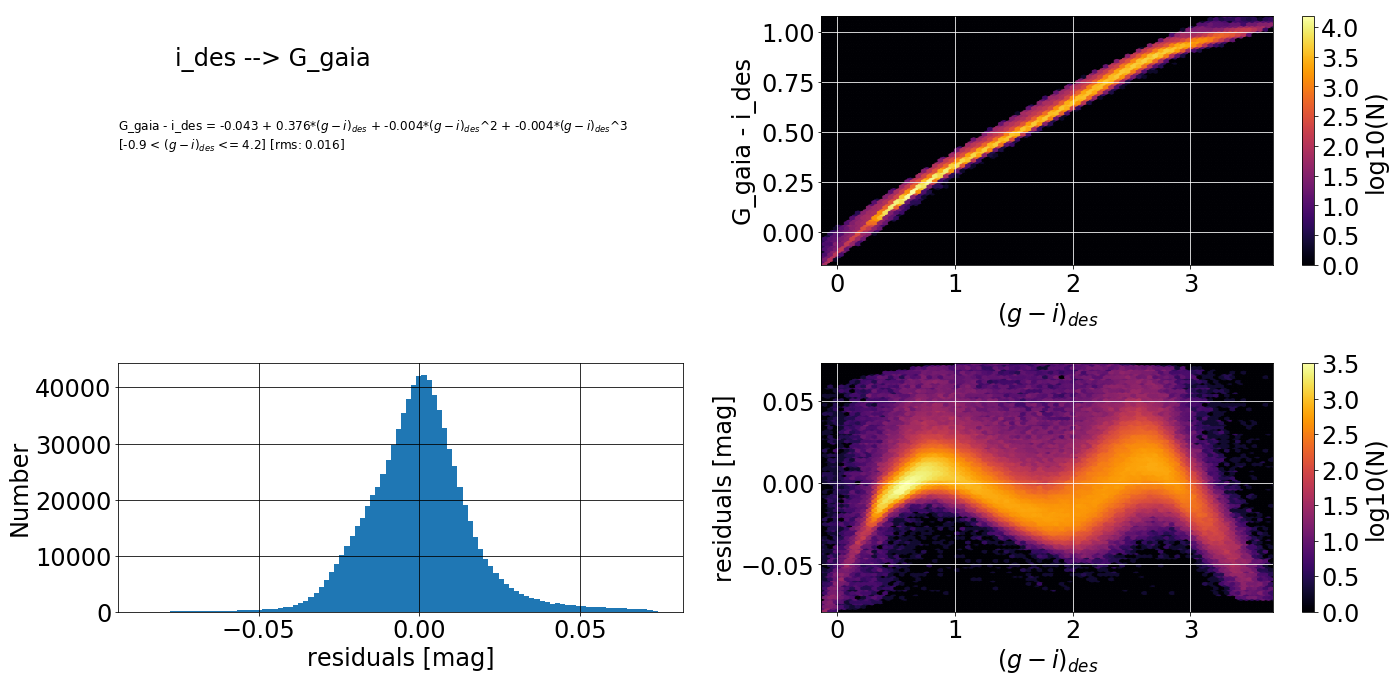

In [16]:
for band in bandList:

    print 
    print 
    print 
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print band
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print 

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Create title/names for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagName = """%s - %s""" % (magName, magName_match)

    
    # Create results output file...
    resultsFile = """%s.dmag_%s-%s.%s.norder%d.csv""" % \
        (resultsFileBaseName, magName, magName_match, color_name_1, norder)

    # Open fit results output file...
    try:
        fout = open(resultsFile, 'w')
    except IOError:
        sys.exit('Unable to write to file ' + resultsFile)

    # Write header to fit results output file...
    hdr = createFitResultsHeaderOutputLine_a(2)
    fout.write(hdr+'\n')

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) )
    mask = mask & mask1 & mask2
    

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0: print band, color_limits_1_dict[band], nbranches

    
    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    dftmp = df[mask]
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0: print band, color_limits_1_dict[band], nbranches

    p_branch_list = []
    
    # Iterate, with sigma-clipping...
    for i in range(niter):

        iiter = i + 1
        if verbose > 0:
            print """   iter%d...""" % ( iiter )

        # make a copy of original df, overwriting the old one...
        df = df[mask].copy()

        df_list = []
        mask_list = []
        #plot1Text = title+"\n"
        plot1Text = ''
        outputLine = ''
        
        for ibranch in range(nbranches):
            
            print '*********************************'
            print ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1] 
            print '*********************************'

            # Extract branch...
            mask_branch = ( (df[color_name_1] >  color_limits_1_dict[band][ibranch]) & \
                            (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]) )

            df_branch = df[mask_branch].copy()

            # ... and extract dmag's and color1's for this branch...
            dmag_branch   = df_branch.loc[:,'dmag']
            color1_branch = df_branch.loc[:,color_name_1]

            # If there are no valid colors on this branch, continue to next branch...
            if len(color1_branch) < 1:
                continue
                
            # Perform fit for each disjoint branch...
            p_branch,perr_branch,rms_branch = transformFit1(color1_branch, dmag_branch, norder, verbose)
            df_branch.loc[:,'res'] = residuals1(p_branch, color1_branch, dmag_branch)
            stddev_branch = df_branch['res'].std()
            mask_branch   = (np.abs(df_branch.res)< nsigma*stddev_branch)
                
      
            # Prepare some text output for plots...
            if norder == 1:
                plot1Text1 = """%s = %.3f + %.3f*%s [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                    (dmagName, p_branch[0], p_branch[1], colorLabel_1, \
                     color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                     stddev_branch)
            elif norder == 2:
                plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2  [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                    (dmagName, p_branch[0], p_branch[1], colorLabel_1, p_branch[2], colorLabel_1, \
                     color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                     stddev_branch)
            elif norder == 3:
                plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2 + %.3f*%s^3\n[%.1f < %s <= %.1f] [rms: %.3f]\n""" % \
                    (dmagName, p_branch[0], p_branch[1], colorLabel_1, p_branch[2], colorLabel_1, p_branch[3], colorLabel_1, \
                     color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                     stddev_branch)
            else:
                plot1Text1 = ''
                
            plot1Text = """%s\n%s""" % (plot1Text, plot1Text1)


            # Prepare some CSV-formatted text output...
            outputLine1 = createFitResultsOutputLine_a(2, \
                                                    p_branch, perr_branch, stddev_branch, \
                                                    magName, magName_match, \
                                                    color_name_1, \
                                                    color_limits_1_dict[band][ibranch], \
                                                    color_limits_1_dict[band][ibranch+1])
            print outputLine1

            outputLine = """%s\n%s""" % (outputLine, outputLine1)
                        
 
            
            # Append branch df and mask to the df_list and mask_list lists, respectively....
            df_list.append(df_branch.copy())
            mask_list.append(mask_branch.copy())
            
            
        
        # Combine df_list dataframes into a single df...    
        df = pd.concat(df_list, ignore_index=True, copy=True)
        
        # Combine mask_list masks into a single masks...    
        mask = pd.concat(mask_list, ignore_index=True, copy=True)
        

    # Output best fits to screen...
    if verbose > 0:
        print 
        print title
        print plot1Text
        print 

    # Write best fits to CSV file...
    fout.write(outputLine+'\n')

    
    # Create QA plots...
    res =  df.loc[:,'res']
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]
    stddev = df['res'].std()
    outputFileName = """%s.dmag_%s-%s.%s.norder%d.qa1.png""" % \
        (qaFileBaseName, magName, magName_match, color_name_1, norder)
    status = transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, 
                                 dmagName, colorLabel_1, stddev, outputFileName)  
    
            

    fout.close()

In [17]:
#%ls -FlthrG transFit.stetson_to_des.*.csv
#%cat transFit.stetson_to_des.dmag_g_des-V.BV.norder1.csv
#%cat transFit.stetson_to_des.dmag_r_des-R.RI.norder1.csv
#%cat transFit.stetson_to_des.dmag_i_des-I.RI.norder1.csv
#%cat transFit.stetson_to_des.dmag_z_des-I.RI.norder1.csv
#%cat transFit.stetson_to_des.dmag_Y_des-I.RI.norder1.csv